<a href="https://colab.research.google.com/github/Ayushmaan-0412/DSP_Project/blob/main/ArithmeticEncoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import time
# Start the timer
start_time = time.time()

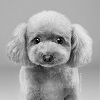

In [ ]:
inputImg = cv2.imread('dog.jpg', 0)  # read the image
#does in grey
cv2_imshow(inputImg)

row = inputImg.shape[0]
col = inputImg.shape[1]

In [ ]:
img = np.array(inputImg).flatten()  # flatten the image into 1d array
frq = np.zeros(256, dtype=int)  # frq of all gray scale levels
blockSize = int(input('1. Enter the block size: '))
floatSize = int(input('2. Enter the float size (16-32-64): '))
total = row * col
if floatSize == 16:
    res = np.zeros(total // blockSize, dtype=np.float16)  # final codes
    # array of probability of each of 256 gray scale levles
    prob = np.zeros(256, dtype=np.float16)
elif floatSize == 32:
    res = np.zeros(total // blockSize, dtype=np.float32)  # final codes
    prob = np.zeros(256, dtype=np.float32)
elif floatSize == 64:
    res = np.zeros(total // blockSize, dtype=np.float64)  # final codes
    prob = np.zeros(256, dtype=np.float64)

1. Enter the block size: 200
2. Enter the float size (16-32-64): 16


In [ ]:

# prob = np.zeros(256)  # array of probability of each of 256 gray scale levles
grayLvl = 256

for i in img:
    frq[i] += 1

for i in range(0, grayLvl):
    prob[i] = frq[i] / (total)

for i in range(1, grayLvl):
    prob[i] += prob[i - 1]

for i in range(0, total, blockSize):
    l = 0.0
    r = 1.0
    for j in range(i, i + blockSize):
        oldLeft = l
        oldRight = r
        # base  + (range) * prob[cur pixel]
        if img[j] != 0:
            l = oldLeft + (oldRight - oldLeft) * prob[img[j] - 1]
        r = oldLeft + (oldRight - oldLeft) * prob[img[j]]
    # result of the block is the average of (upper - lower)
    it = int(i / blockSize)
    res[it] = (l + r) / 2

# export encoded tags && pro
np.save('./encoded-image', res)
np.save('./probability', prob)
blockSizeFile = open('blockSizeFile.txt', "w")
blockSizeFile.write(str(blockSize))  # read block size
blockSizeFile.write('\n' + str(row))  # read row dimension
blockSizeFile.write('\n' + str(col))  # read col dimension
end_time = time.time()

# Calculate the elapsed time
encoding_time = end_time - start_time

# Print the encoding time in seconds
print(f"Encoding time: {encoding_time} seconds")
# terminate showing the image on pressing any key
cv2.waitKey(0)
cv2.destroyAllWindows()

Encoding time: 14.531979084014893 seconds


In [ ]:
import os

# Original image file path
original_image_path = 'dog.jpg'

# Load the original image
inputImg = cv2.imread(original_image_path, 0)

# Dimensions of the original image
row = inputImg.shape[0]
col = inputImg.shape[1]

# Size of the original image in bytes
original_image_size = os.path.getsize(original_image_path)

# Compressed data file path and its size
compressed_data_path = './encoded-image.npy'
compressed_data_size = os.path.getsize(compressed_data_path)

# Calculate the compression ratio
compression_ratio = original_image_size / compressed_data_size

# Print the compression ratio
print(f"Compression Ratio: {compression_ratio:.2f}")

Compression Ratio: 25.59


In [ ]:
#decoding
from PIL import Image
import numpy as np
res = np.load('./encoded-image.npy')
prob = np.load('./probability.npy')

grayLvl = 256
blockSizeFile = open('blockSizeFile.txt', "r")
blockSize = int((float(blockSizeFile.readline())))
row = int(blockSizeFile.readline())
col = int(blockSizeFile.readline())
total = row * col
out = np.zeros(total)

In [ ]:
for i in range(0, total, blockSize):
    l = 0.0
    r = 1.0
    for j in range(i, i + blockSize):  # loop over block size  = 16
        for k in range(0, grayLvl):
            tag = res[int(i / blockSize)]
            if tag < l + (r - l) * prob[k]:  # if This interval cover me
                oldLeft = l
                oldRight = r
                if k != 0:
                    l = oldLeft + (oldRight - oldLeft) * prob[k - 1]
                r = oldLeft + (oldRight - oldLeft) * prob[k]
                out[j] = k
                break

print(out)
out = np.array(out).reshape((row, col))

[177. 177. 178. ... 174. 174. 174.]


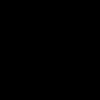

Decoding time: 4.3608081340789795 seconds


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:

import numpy as np
import cv2
start_time = time.time()
# Load the encoded data and probability
res = np.load('./encoded-image.npy')
prob = np.load('./probability.npy')

# Load block size and image dimensions
with open('blockSizeFile.txt', 'r') as blockSizeFile:
    blockSize = int(float(blockSizeFile.readline()))
    row = int(blockSizeFile.readline())
    col = int(blockSizeFile.readline())

total = row * col
decoded_image = np.zeros(total, dtype=np.uint8)

floatSize = res.dtype.itemsize * 8  # Calculate float size based on data type
grayLvl = 256

for i in range(0, total, blockSize):
    l = 0.0
    r = 1.0
    it = int(i / blockSize)
    code = res[it]

    for j in range(i, i + blockSize):
      for pixel_value in range(1, grayLvl):  # Change the range to 1 to 255
        oldLeft = l
        oldRight = r
        l = oldLeft + (oldRight - oldLeft) * prob[pixel_value - 1]
        r = oldLeft + (oldRight - oldLeft) * prob[pixel_value]
        if l <= code < r:
            decoded_image[j] = pixel_value - 1
            break

# Reshape the decoded image to its original dimensions
decoded_image = decoded_image.reshape(row, col)

# Display the decoded image
cv2_imshow(decoded_image)

# Save the decoded image to a file
cv2.imwrite('decoded_dog.jpg', decoded_image)
end_time = time.time()

# Calculate the elapsed time
decoding_time = end_time - start_time
# Terminate the image display when any key is pressed
# Print the decoding time in seconds
print(f"Decoding time: {decoding_time} seconds")
# Show the decoded image
display(decoded_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# Load the original image
original_img = cv2.imread('dog.jpg', 0)

# Load the decoded image
decoded_img = cv2.imread('decoded_dog.jpg', 0)

if original_img is None:
    print("Error: Could not load the original image.")
elif decoded_img is None:
    print("Error: Could not load the decoded image.")
else:
    # Calculate the Mean Squared Error (MSE)
    mse = np.mean((original_img - decoded_img) ** 2)

    # Calculate the maximum possible pixel value
    max_pixel_value = 255  # For 8-bit grayscale images

    # Calculate the PSNR
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))

    print(f'PSNR: {psnr} dB')

PSNR: 27.49768773490345 dB


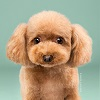

In [ ]:
from PIL import Image
from IPython.display import display
# Load the image
image = Image.open("dog.jpg")
display(image)

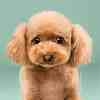

In [ ]:

# Load the original image
original_img = cv2.imread('dog.jpg')

# Define the compression quality (adjust this value)
compression_quality = 26  # You may need to adjust this value

# Encode the image with JPEG compression
_, encoded_img = cv2.imencode('.jpg', original_img, [int(cv2.IMWRITE_JPEG_QUALITY), compression_quality])

# Decode the image to view the compressed result
compressed_img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
cv2.imwrite('compressed_img.jpg', compressed_img)
# Show the compressed image
cv2_imshow(compressed_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
